## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import cfe.regression as rgsn
import matplotlib.pyplot as plt

Missing dependencies for OracleDemands.


### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [3]:
InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

#### Prices, FCT, RDI



In [4]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [5]:
p

j                       Beans   Beef         Beer  Biscuits   Bongo   
t       m                                                             
2005-06 Central    650.000000   2500  3000.000000       NaN     NaN  \
2005-6  Eastern    550.000000   2400  2000.000000       NaN     NaN   
        Northern   434.151414   2500  2400.000000       NaN     NaN   
        Western    500.000000   2200  2500.000000       NaN     NaN   
2009-10 Central   1350.000000   5000  4000.000000       NaN     NaN   
        Eastern   1200.000000   4000  2750.000000       NaN     NaN   
        Northern  1000.000000   4500  2600.000000       NaN     NaN   
        Western    975.000000   4000  3200.000000       NaN     NaN   
2010-11 Central   1650.000000   5500  4000.000000       NaN     NaN   
        Eastern   1300.000000   5000  2600.000000       NaN     NaN   
        Northern  1600.000000   5000  3000.000000       NaN     NaN   
        Western   1200.000000   5000  4000.000000       NaN     NaN   
2011-12 Central   1750.000000   7500  5000.000000       NaN     NaN   
        Eastern   1400.000000   6800  4228.571429       NaN     NaN   
        Northern  2000.000000   7000  3800.000000       NaN     NaN   
        Western   1250.000000   7000  4000.000000       NaN     NaN   
2013-14 Central   2000.000000   8000  5857.142857       NaN     NaN   
        Eastern   1750.000000   7000  4750.000000       NaN     NaN   
        Northern  2000.000000   7000  4000.000000       NaN     NaN   
        Western   1700.000000   7000  5000.000000       NaN     NaN   
2015-16 Central   2200.000000   9000  5833.333333       NaN     NaN   
        Eastern   2200.000000   8000  4200.000000       NaN     NaN   
        Northern  2000.000000   8000  4000.000000       NaN     NaN   
        Western   1800.000000   8000  6000.000000       NaN     NaN   
2018-19 Central   2100.000000  10000  5500.000000    2000.0  2000.0   
        Eastern   1900.000000   9000  5250.000000    3000.0  1000.0   
        Northern  5500.000000  10000  4300.000000    2000.0   800.0   
        Western   1750.000000  10000  6500.000000    2000.0  2000.0   
2019-20 Central   2500.000000  12000  6000.000000    5000.0  1000.0   
        Eastern   2275.000000  10000  6785.714286    2000.0  1000.0   
        Northern  8833.333333  10000  6500.000000    2000.0  1000.0   
        Western   2200.000000  10000  5000.000000    2000.0  1250.0   

j                       Bread  Butter, etc.     Cabbages         Cake   
t       m                                                               
2005-06 Central   1400.000000   3000.000000  1400.000000          NaN  \
2005-6  Eastern   1000.000000   3300.000000  1050.000000          NaN   
        Northern  1000.000000   1500.000000  1225.000000          NaN   
        Western   1000.000000   3000.000000  1050.000000          NaN   
2009-10 Central   2400.000000   4800.000000  1750.000000          NaN   
        Eastern   2000.000000   4400.000000  1750.000000          NaN   
        Northern  2000.000000   3000.000000  1750.000000          NaN   
        Western   2400.000000   4999.999863  1750.000000          NaN   
2010-11 Central   3571.428571   4545.454545  1341.514143          NaN   
        Eastern   2000.000000   4800.000000  1341.514143          NaN   
        Northern  2000.000000   5200.000000  1679.389313          NaN   
        Western   3428.571429   2500.000000  1341.514143          NaN   
2011-12 Central   4000.000000   8000.000000  1679.389313          NaN   
        Eastern   4000.000000   1000.000000  1679.389313          NaN   
        Northern  2000.000000   3500.000000  2142.857143          NaN   
        Western   3500.000000   3100.000000  1428.571429          NaN   
2013-14 Central   3500.000000   6538.461538  1796.202757          NaN   
        Eastern   3500.000000   7000.000000  1428.571429          NaN   
        Northern  2000.000000   5230.769231  2142.857143          NaN   
        Western   3500.000000   6000.000000  1878.11

In [6]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomatoes,180,9.0,10.0,150,100,39.0,3.0,5.94,0.19,0.37,420,0.0,0.80,127,2.0
Waragi,2630,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
Watermelon,300,6.1,4.0,30,70,75.5,2.4,1.78,0.21,0.33,280,0.0,0.45,81,1.0


In [7]:
rdi

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [8]:
r = rgsn.read_pickle('uganda_2019-20.pickle')  # Assumes you've already set this up e.g., in Project 3

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [9]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2019-20',level='t').mean()
pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [10]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [11]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Beans,Beef,Biscuits,Bread,Cabbages,Cassava,Chapati,Cooking Oil,Dodo,Eggs,...,Rice,Salt,Sim Sim,Soda,Sorghum,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.908344,0.873736,0.278641,0.679694,0.542311,7.076232,1.225904,0.768595,2.102513,1.300093,...,1.904098,0.210626,0.169969,0.828589,1.032246,1.855447,9.106649,0.020781,2.065636,0.547677
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.630212,0.704890,0.332241,0.547917,0.386812,4.651378,1.117598,0.688879,1.406102,1.218035,...,1.200659,0.159736,0.182561,0.863060,0.734592,1.631692,5.637060,0.015357,1.934006,1.241320
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.613338,0.545572,0.129055,0.371819,0.290441,5.161206,0.725595,0.516824,1.212362,0.887650,...,0.853833,0.156937,0.098278,0.419683,0.466584,0.810668,5.261903,0.011435,1.357342,0.826227
1013000201,2019-20,Central,0.962721,1.172347,1.375567,1.003591,0.523225,3.037451,1.864472,0.697341,2.265463,1.793179,...,1.355894,0.143342,0.210153,1.689991,0.925546,2.539598,4.600645,0.029232,2.506099,0.878415
1013000202,2019-20,Central,0.783036,0.588576,0.214716,0.411769,0.272860,3.188167,0.608036,0.379958,1.262848,1.067309,...,0.643904,0.167656,0.066803,0.347818,0.351393,0.987588,3.197720,0.013198,1.131102,0.537512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,1.474756,1.084495,0.410866,0.612537,0.532731,9.631213,1.567699,0.878762,2.330314,1.518435,...,2.209271,0.280835,0.231877,1.055073,1.601185,3.907814,13.453670,0.018543,2.189298,1.929582
c33f6cb57d9849949e08a7350dabb829,2019-20,Central,0.642402,0.678325,0.525649,0.425417,0.313321,2.507347,0.838033,0.409256,1.410044,1.156874,...,0.680075,0.119045,0.100621,0.794967,0.405909,1.185200,3.030198,0.017108,1.345186,0.515554
d10a687889de469687377204195f3db0,2019-20,Western,1.293502,0.857205,0.451531,0.512783,0.420744,4.915754,0.880891,0.635583,1.252812,1.400779,...,0.730574,0.249491,0.527720,0.737261,1.414265,1.657020,3.251340,0.025992,2.019768,0.922988


In [12]:
qhat.sum().sort_values(ascending=False)

j
Matoke            20796.806769
Cassava           18018.337660
Sweet Potatoes    17067.729404
Mangos            15478.162944
Maize              9499.406076
Oranges            8254.899097
Tomatoes           7084.219807
Fish (dried)       6646.018826
Sweet Bananas      6567.613786
Sorghum            6309.194309
Milk (fresh)       5841.467089
Other Veg.         5539.272674
Dodo               5370.904592
Chapati            4509.255999
Rice               4313.048887
Beans              4170.330876
Eggs               4140.716486
Fish (fresh)       3615.323949
Waragi             3061.853989
Beef               3041.833289
Other Fruits       3017.074540
Soda               2872.127332
Goat               2824.965687
Pork               2567.524463
Millet             2564.715750
Bread              2509.861734
Cooking Oil        2382.298310
Peas               1913.676909
Cabbages           1612.063103
Onions             1586.687834
Ground Nuts        1472.788397
Biscuits           1468.490278
Sim Si

In [13]:
qhat.mean().sort_values(ascending=False)

j
Matoke            7.716811
Cassava           6.685840
Sweet Potatoes    6.333109
Mangos            5.743289
Maize             3.524826
Oranges           3.063042
Tomatoes          2.628653
Fish (dried)      2.466055
Sweet Bananas     2.436962
Sorghum           2.341074
Milk (fresh)      2.167520
Other Veg.        2.055389
Dodo              1.992915
Chapati           1.673193
Rice              1.600389
Beans             1.547433
Eggs              1.536444
Fish (fresh)      1.341493
Waragi            1.136124
Beef              1.128695
Other Fruits      1.119508
Soda              1.065724
Goat              1.048225
Pork              0.952699
Millet            0.951657
Bread             0.931303
Cooking Oil       0.883970
Peas              0.710084
Cabbages          0.598168
Onions            0.588752
Ground Nuts       0.546489
Biscuits          0.544894
Sim Sim           0.368270
Salt              0.258087
Tea               0.026291
dtype: float64

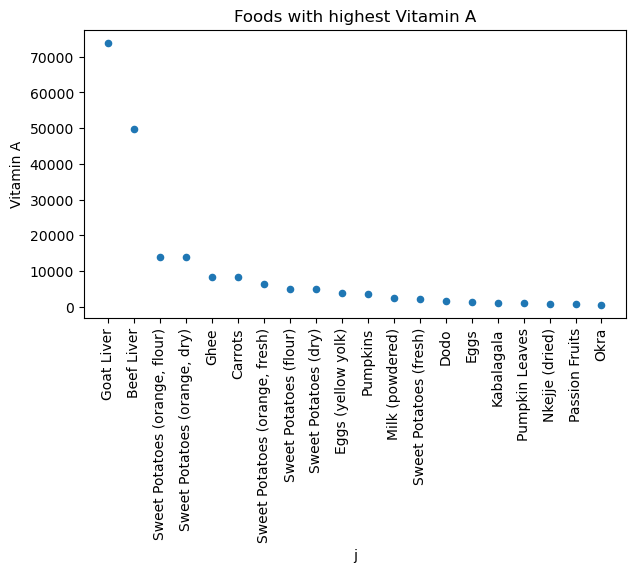

In [14]:
fct.sort_values(by=['Vitamin A'],ascending=False).head(20).reset_index().plot.scatter(x='j',y='Vitamin A',figsize=(7,6));
plt.xticks(rotation=90);
plt.yticks(np.arange(0,80000,10000))
plt.title('Foods with highest Vitamin A')
plt.subplots_adjust(bottom=0.4);

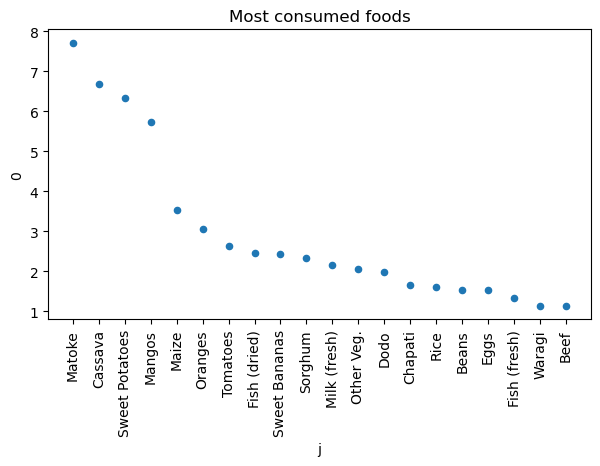

In [15]:
pd.DataFrame(qhat.mean().sort_values(ascending=False)).head(20).reset_index().plot.scatter(x='j',y=0,figsize=(7,5))
plt.xticks(rotation=90);
plt.title('Most consumed foods')
plt.subplots_adjust(bottom=0.3);

Finally, define a function to change a single price in the vector $p$:



In [16]:
def my_prices(p0,p=pbar,j='Sweet Potatoes'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



<IPython.core.display.Javascript object>


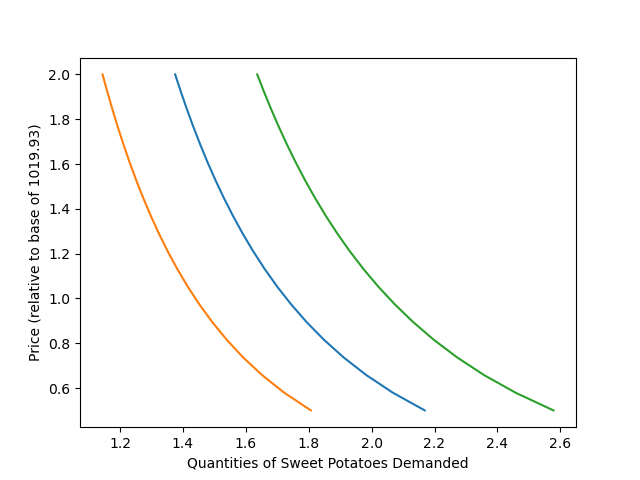

Text(0.5, 0, 'Quantities of Sweet Potatoes Demanded')

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Sweet Potatoes'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



<IPython.core.display.Javascript object>


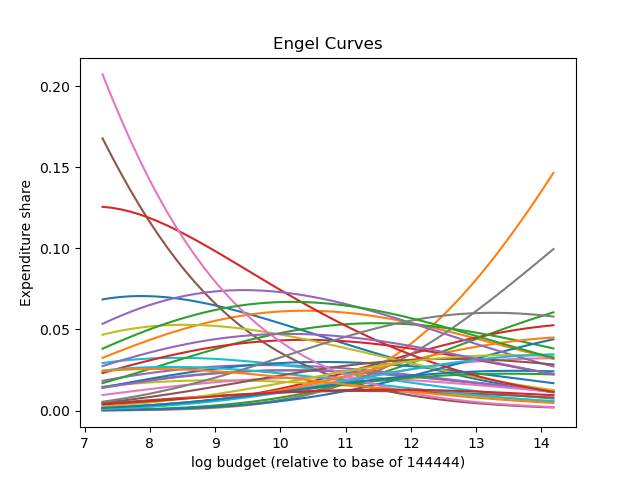

Text(0.5, 1.0, 'Engel Curves')

In [18]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [19]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomatoes,180,9.0,10.0,150,100,39.0,3.0,5.94,0.19,0.37,420,0.0,0.80,127,2.0
Waragi,2630,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
Watermelon,300,6.1,4.0,30,70,75.5,2.4,1.78,0.21,0.33,280,0.0,0.45,81,1.0


In [20]:
fct.sort_values(by=['Vitamin A'],ascending=False).head(10)

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Goat Liver,1390,204.0,0.0,2300,70,18.0,74.0,161.10,36.30,3.40,73910,900.5,9.00,40,47.0
Beef Liver,1350,204.0,0.0,2900,50,39.0,49.0,131.75,27.55,1.89,49680,593.0,10.83,13,40.0
"Sweet Potatoes (orange, flour)",3430,64.0,110.0,400,1140,807.0,24.0,21.22,2.33,2.50,13900,0.0,7.96,71,11.0
"Sweet Potatoes (orange, dry)",3430,64.0,110.0,400,1140,807.0,24.0,21.22,2.33,2.50,13900,0.0,7.96,71,11.0
Ghee,8760,3.0,0.0,0,40,0.0,0.0,0.03,0.05,0.01,8400,0.1,0.01,0,0.0
Carrots,410,9.0,30.0,190,330,96.0,3.0,9.83,0.58,0.66,8350,0.0,1.38,59,2.0
"Sweet Potatoes (orange, fresh)",1230,23.0,40.0,160,430,289.0,9.0,8.00,0.88,1.12,6300,0.0,3.00,34,4.0
Sweet Potatoes (flour),3430,64.0,110.0,400,1140,807.0,24.0,21.22,2.33,2.50,4960,0.0,7.96,71,11.0
Sweet Potatoes (dry),3430,64.0,110.0,400,1140,807.0,24.0,21.22,2.33,2.50,4960,0.0,7.96,71,11.0


In [21]:
fct.sort_values(by=['Vitamin B-12'],ascending=False).head(10)

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Goat Liver,1390,204.0,0.0,2300,70,18.0,74.0,161.10,36.30,3.40,73910,900.5,9.00,40,47.0
Beef Liver,1350,204.0,0.0,2900,50,39.0,49.0,131.75,27.55,1.89,49680,593.0,10.83,13,40.0
Nkejje (dried),3670,418.0,0.0,230,1320,0.0,26.0,74.68,5.41,2.14,650,317.3,7.01,16,23.0
Perch (dried),4100,874.0,0.0,210,3610,0.0,41.0,68.52,4.51,3.00,370,81.4,5.14,65,50.0
Tilapia (dried),4130,865.0,0.0,930,430,0.0,26.0,159.51,2.57,1.59,0,61.2,6.27,0,13.0
Milk (powdered),4960,263.0,0.0,370,9120,384.0,5.0,6.46,12.05,2.83,2570,32.5,3.02,86,33.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
Fresh Fish,1390,193.0,0.0,10,110,0.0,4.0,23.00,1.70,1.30,300,24.0,4.00,16,5.0


In [22]:
fct.sort_values(by=['Calcium'],ascending=False).head(10)

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Sim Sim,5730,177.0,118.0,970,9750,235.0,145.5,45.20,2.50,7.90,0,0.0,7.90,0,77.5
Sim Sim (paste),5860,181.0,60.0,1000,9600,241.0,192.0,67.00,2.00,2.40,30,0.0,8.16,0,73.0
Milk (powdered),4960,263.0,0.0,370,9120,384.0,5.0,6.46,12.05,2.83,2570,32.5,3.02,86,33.0
Okra,580,44.0,20.0,1180,5300,90.0,7.0,2.00,28.00,2.50,610,0.0,0.00,590,20.0
Perch (dried),4100,874.0,0.0,210,3610,0.0,41.0,68.52,4.51,3.00,370,81.4,5.14,65,50.0
Dodo,230,25.0,0.0,850,2150,40.0,23.0,6.58,1.58,0.27,1460,0.0,1.92,433,9.0
Garlic,1490,64.0,20.0,30,1810,331.0,17.0,7.00,1.10,2.00,0,0.0,12.35,312,12.0
Bongo,640,33.0,0.0,50,1620,45.0,1.0,1.00,1.50,0.20,370,4.4,0.36,0,6.0
Bread,2660,76.0,20.0,1110,1510,506.0,37.0,43.85,3.31,4.55,0,0.0,0.84,0,7.0


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [23]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beef', 'Biscuits', 'Bread', 'Cabbages', 'Chapati', 'Cooking Oil',
       'Dodo', 'Eggs', 'Mangos', 'Millet', 'Onions', 'Oranges', 'Peas', 'Pork',
       'Sim Sim', 'Soda', 'Sorghum', 'Sweet Bananas', 'Tomatoes', 'Waragi'],
      dtype='object', name='j')


In [24]:
c0

i,00c9353d8ebe42faabf5919b81d7fae7,0d0e29faff394154a69562b4527b48b8,0e03e253c35d4333a1ffad2df9d38850,1013000201,1013000202,1013000204,1021000108,1021000109,1021000111,1021000506,...,a98bebba177243668464e31f6d2bb92d,ab5cbcbe0e14402aae73b91c6917a595,acb16f9b068549d8a80a37c9d638742f,ad9b7c4ba614444bb8004eb658693c9f,bfd8253bd59c4f3199fb4b83b9cee7a6,bfdf0d66403440ceab439b1e1c47cdea,c33f6cb57d9849949e08a7350dabb829,d10a687889de469687377204195f3db0,d24fa50d02c041969a42102d8ebdadc9,e07bc322c4884559b4b8ca75c945dd3e
t,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,...,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20
m,Eastern,Eastern,Eastern,Central,Central,Central,Central,Central,Central,Central,...,Western,Eastern,Western,Eastern,Eastern,Eastern,Central,Western,Eastern,Northern
j,,,,,,,,,,,,,,,,,,,,,
Beef,0.873736,0.704890,0.545572,1.172347,0.588576,1.705933,0.737755,1.217563,1.213859,1.057732,...,1.983653,0.649323,1.055683,1.705187,1.503773,1.084495,0.678325,0.857205,1.502435,0.862472
Biscuits,0.278641,0.332241,0.129055,1.375567,0.214716,2.625925,0.261157,0.673216,0.389732,0.256558,...,0.600420,0.282592,0.565255,0.684035,0.345660,0.410866,0.525649,0.451531,0.499514,0.476346
Bread,0.679694,0.547917,0.371819,1.003591,0.411769,1.898700,0.425590,1.234686,1.002343,0.714313,...,1.788840,0.536612,0.892166,1.676085,1.196680,0.612537,0.425417,0.512783,1.224655,0.724953
Cabbages,0.542311,0.386812,0.290441,0.523225,0.272860,0.718588,0.314761,0.538368,0.560411,0.473622,...,0.844868,0.401139,0.484722,0.975898,0.740532,0.532731,0.313321,0.420744,0.760732,0.748186
Chapati,1.225904,1.117598,0.725595,1.864472,0.608036,4.190600,0.767522,1.694357,2.171155,1.282334,...,2.772812,1.115164,1.594060,2.556188,2.475050,1.567699,0.838033,0.880891,2.720952,1.446448
Cooking Oil,0.768595,0.688879,0.516824,0.697341,0.379958,1.142482,0.451537,0.974508,0.873992,0.733937,...,1.563699,0.660384,0.912406,1.237726,1.177505,0.878762,0.409256,0.635583,1.220834,0.884712
Dodo,2.102513,1.406102,1.212362,2.265463,1.262848,2.934476,1.567799,2.247284,2.322878,1.917022,...,3.042107,1.360018,1.452504,3.139154,3.167711,2.330314,1.410044,1.252812,3.314394,1.550971


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [25]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,00c9353d8ebe42faabf5919b81d7fae7,0d0e29faff394154a69562b4527b48b8,0e03e253c35d4333a1ffad2df9d38850,1013000201,1013000202,1013000204,1021000108,1021000109,1021000111,1021000506,...,a98bebba177243668464e31f6d2bb92d,ab5cbcbe0e14402aae73b91c6917a595,acb16f9b068549d8a80a37c9d638742f,ad9b7c4ba614444bb8004eb658693c9f,bfd8253bd59c4f3199fb4b83b9cee7a6,bfdf0d66403440ceab439b1e1c47cdea,c33f6cb57d9849949e08a7350dabb829,d10a687889de469687377204195f3db0,d24fa50d02c041969a42102d8ebdadc9,e07bc322c4884559b4b8ca75c945dd3e
t,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,...,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20
m,Eastern,Eastern,Eastern,Central,Central,Central,Central,Central,Central,Central,...,Western,Eastern,Western,Eastern,Eastern,Eastern,Central,Western,Eastern,Northern
n,,,,,,,,,,,,,,,,,,,,,
Energy,34279.310477,32355.450360,22060.620296,46690.228262,19896.924750,79031.265805,24161.351849,48592.831111,45061.192428,35952.286939,...,102102.378612,31487.979190,54039.668071,75711.958741,62061.011135,51445.085092,24093.078697,37178.769958,67803.612157,53951.989701
Protein,958.221727,848.291671,606.550231,1430.201590,655.967358,2198.620670,782.230906,1479.898620,1285.913078,1068.267730,...,2907.041311,841.020327,1518.187079,2098.488083,1690.398619,1308.048475,780.167783,1107.343632,1764.450600,1597.985807
Fiber,451.701082,385.098175,257.000644,521.047820,226.641875,820.025958,274.048694,549.012040,493.144652,406.829999,...,1526.727586,389.781560,722.203037,1152.818738,797.202890,737.391004,266.644270,486.270718,889.695022,791.659163
Folate,7937.213883,6480.064258,4645.968388,10440.967806,4727.570937,16215.674085,5554.150916,10309.673309,9113.777735,7581.336834,...,19133.901097,6304.773764,9998.610193,17553.980356,12673.612232,10882.814392,5540.400994,7314.852569,13702.791000,10305.697729
Calcium,12256.152457,10058.249503,7137.179975,15231.774571,6834.371519,24477.484390,8241.308747,14937.404781,14341.457653,11283.826862,...,31937.343051,9701.681983,17438.516919,28109.155141,19748.143513,15719.899096,8124.459399,13157.113011,21487.304482,15545.830657
Carbohydrate,4481.664562,3865.191413,2496.602744,6119.095183,2261.808888,10605.864712,2751.507369,5908.342334,5410.644500,4124.866224,...,14853.094826,3933.152678,7008.748229,10931.119046,8174.556250,7011.353879,2909.292425,4527.807772,9138.590392,7931.868204
Iron,260.052962,214.972363,149.482896,347.948975,150.080223,554.531545,180.492003,353.287413,319.227503,255.969434,...,864.752802,215.977115,429.298229,575.416160,448.933480,337.713121,180.999168,314.095233,480.181213,444.142268


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [26]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



<IPython.core.display.Javascript object>


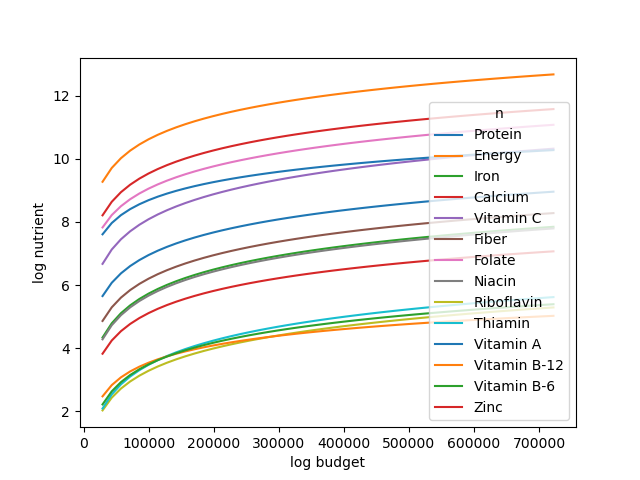

Text(0, 0.5, 'log nutrient')

In [27]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C','Fiber','Folate','Niacin','Riboflavin','Thiamin','Vitamin A','Vitamin B-12','Vitamin B-6','Zinc']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



<IPython.core.display.Javascript object>


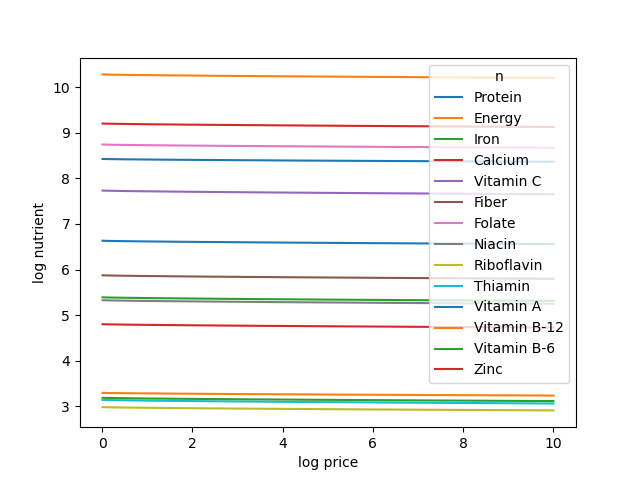

Text(0, 0.5, 'log nutrient')

In [28]:
USE_GOOD = 'Sweet Potatoes'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [29]:
# In first round, averaged over households and villages
dbar = r.d.mean().iloc[:-2]

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [30]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi.replace('',0)@dbar

hh_rdi

n
Energy           9302.189239
Protein           207.761410
Fiber             130.230649
Folate           1742.820037
Calcium          5693.803340
Carbohydrate      692.063080
Iron               56.743228
Magnesium        1492.808905
Niacin             66.481633
Phosphorus       4292.437848
Potassium       23178.552876
Riboflavin          5.208200
Thiamin             5.059369
Vitamin A        3472.912801
Vitamin B-12       10.456920
Vitamin B-6         5.785158
Vitamin C         312.990724
Vitamin E          64.935436
Vitamin K         414.634508
Zinc               42.189610
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [31]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



In [32]:
UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C','Fiber','Folate','Niacin','Riboflavin','Thiamin','Vitamin A','Vitamin B-12','Vitamin B-6','Zinc']

<IPython.core.display.Javascript object>


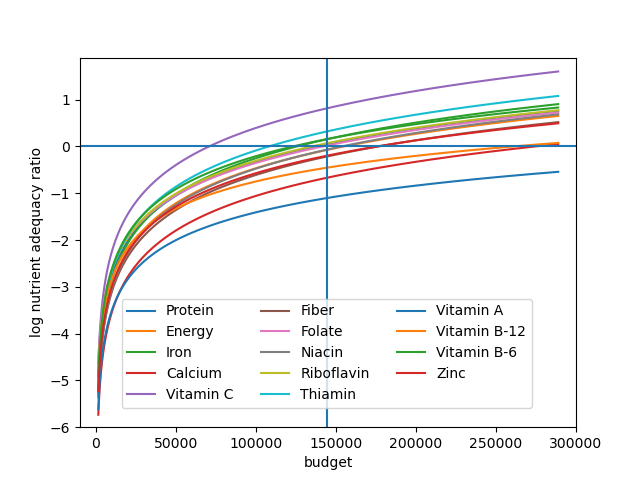

In [33]:
X = np.geomspace(.01*xref,2*xref,100)

adequacy = pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T
fig,ax = plt.subplots()
ax.plot(adequacy)
ax.legend(UseNutrients,loc='best',bbox_to_anchor=(0.07,0.2),ncol=3)
ax.set_xlim(-10000, 300000)
ax.set_ylim(-6, 1.9)
ax.set_xlabel('budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)
ax.axvline(xref)

In [34]:
UseNutrients = ['Vitamin A']

<IPython.core.display.Javascript object>


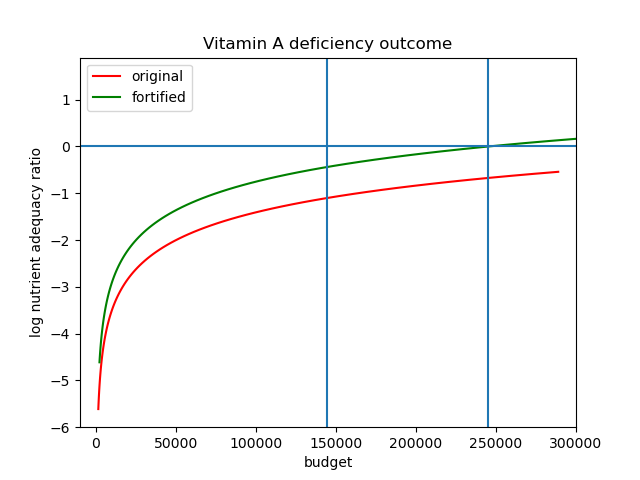

In [35]:
X = np.geomspace(.01*xref,2*xref,100)

adequacy = pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T
budget = adequacy.index.values
log_adequacy = adequacy.values
fortified_budget = budget*1.5 #fortified food is 1.5x more expensive
fortified_log_adequacy = log_adequacy + np.log10(10) #fortified food has 10x Vitamin A

fig,ax = plt.subplots()
ax.plot(budget,log_adequacy,color='red')
ax.plot(fortified_budget,fortified_log_adequacy,color='green')

#adequacy.plot()#.line(color='red')
#plt.legend(UseNutrients,loc='best',bbox_to_anchor=(0.07,0.2),ncol=3)
ax.set_xlim(-10000, 300000)
ax.set_ylim(-6, 1.9)
ax.set_title('Vitamin A deficiency outcome')
ax.set_xlabel('budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.legend(['original','fortified'])
ax.axhline(0)
ax.axvline(xref)

indx = np.where(np.sign(fortified_log_adequacy)>0)[0][0]
y1 = fortified_log_adequacy[indx-1][0]
y2 = fortified_log_adequacy[indx][0]
x1 = fortified_budget[indx-1]
x2 = fortified_budget[indx]
new_budget = x1 + (x2-x1)/(y2-y1) * (0-y1)
ax.axvline(new_budget)

In [36]:
budget_ratio = new_budget/xref

In [37]:
budget_ratio

1.6978727388795036

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



<IPython.core.display.Javascript object>


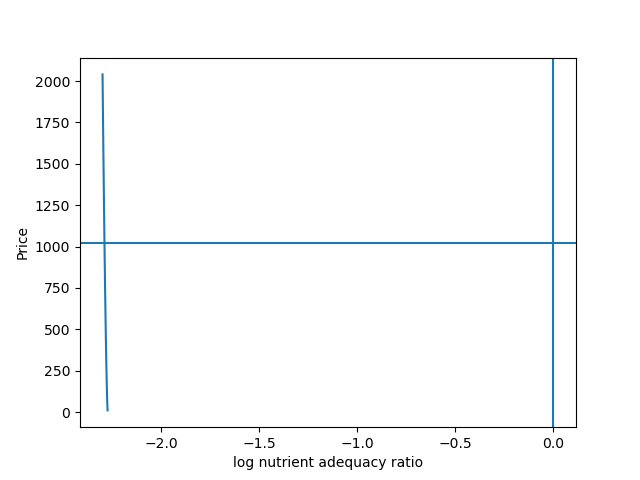

Text(0.5, 0, 'log nutrient adequacy ratio')

In [38]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin A'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

## Costs



In [39]:
import cfe.regression as rgsn

r = rgsn.read_pickle('uganda_2019-20.pickle')  # Assumes you've already set this up e.g., in Project 3

#### Reference Prices



In [40]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2019-20',level='t').mean()
pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

#### Budgets



In [41]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Changing one price, holding others fixed



In [42]:
def my_prices(p0,p=pbar,j='Sweet Potatoes'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

#### Marshallian vs. Hicksian Demand Curves



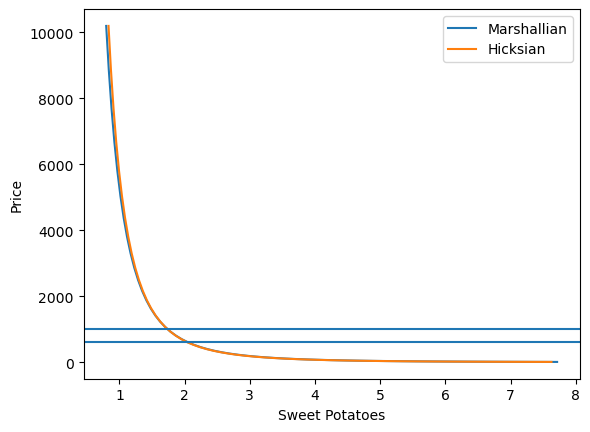

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Sweet Potatoes'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = r.indirect_utility(x0,pbar)

plt.plot([r.demands(x0,my_prices(p0,j=my_j))[my_j] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,j=my_j),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))
plt.axhline(pbar.loc[my_j])
plt.axhline(pbar.loc[my_j]/budget_ratio)

#### Welfare measures



In [44]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation



Text(0.5, 1.0, 'Monetary cost of decreased sweet potato price')

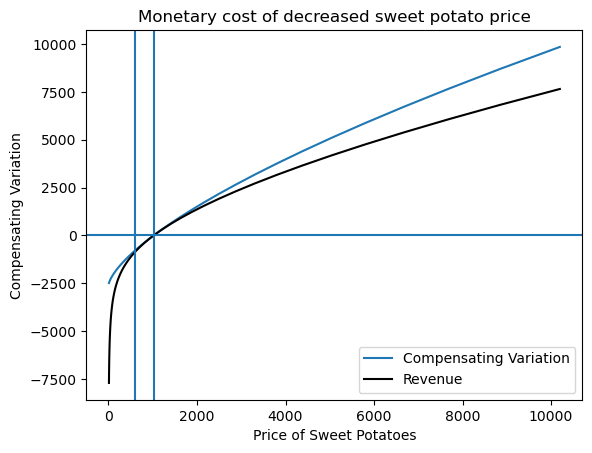

In [45]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(p0,j=my_j),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])
ax1.axvline(pbar.loc[my_j]/budget_ratio)
plt.title('Monetary cost of decreased sweet potato price')

#### Deadweight Loss



In [46]:
245000/xref

1.696157288423148

Text(0.5, 1.0, 'Deadweight loss of decreased sweet potato price')

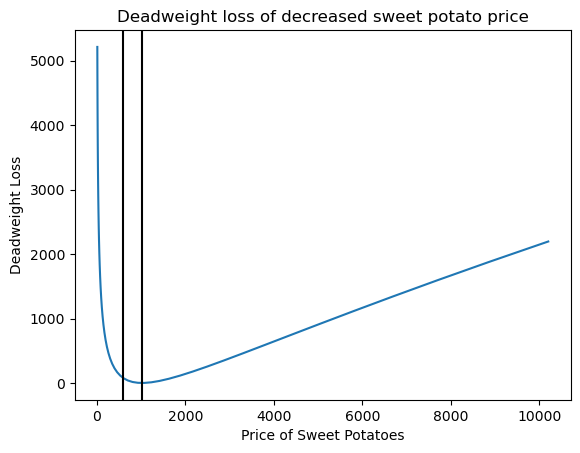

In [47]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(p0,j=my_j)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")
ax1.axvline(pbar.loc[my_j],color='black')
ax1.axvline(pbar.loc[my_j]/budget_ratio,color='black')
plt.title('Deadweight loss of decreased sweet potato price')